# FastICA for EEG Denoising Under tES

We provide in this notebook a simple example of applying the `FastICA` algorithm to EEG denoising under tES (Transcranial Electrical Stimulation).

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FastICA
from numpy.typing import NDArray
from typing import Any
from tqdm import tqdm
from benchmark_metrics import *

def load_data(folder_path: str) -> dict[str, dict[str, NDArray[np.float32]]]:
    dataset = {}
    for split in ['train', 'val', 'test']:
        dataset[split] = {}
        dataset[split]['denoised'] = np.load(folder_path + f'Denoiseoutput_{split}.npy')
        dataset[split]['ground_truth'] = np.load(folder_path + f'EEG_{split}.npy')
        dataset[split]['noisy_input'] = np.load(folder_path + f'noiseinput_{split}.npy')
    print('Finished Loading EEG Data!')
    return dataset

## 1. Visual Example of FastICA Denoising

In [2]:
data = load_data('data/tDCS/')

Finished Loading EEG Data!


In [3]:
fastICA = FastICA(n_components = 1, random_state = 42, whiten = 'unit-variance')
split_data = fastICA.fit_transform(data['test']['noisy_input'][0].reshape(512, 1)).reshape(512)
print(f'Finished Running FastICA Algorithm -> Shape: {split_data.shape}')

Finished Running FastICA Algorithm -> Shape: (512,)


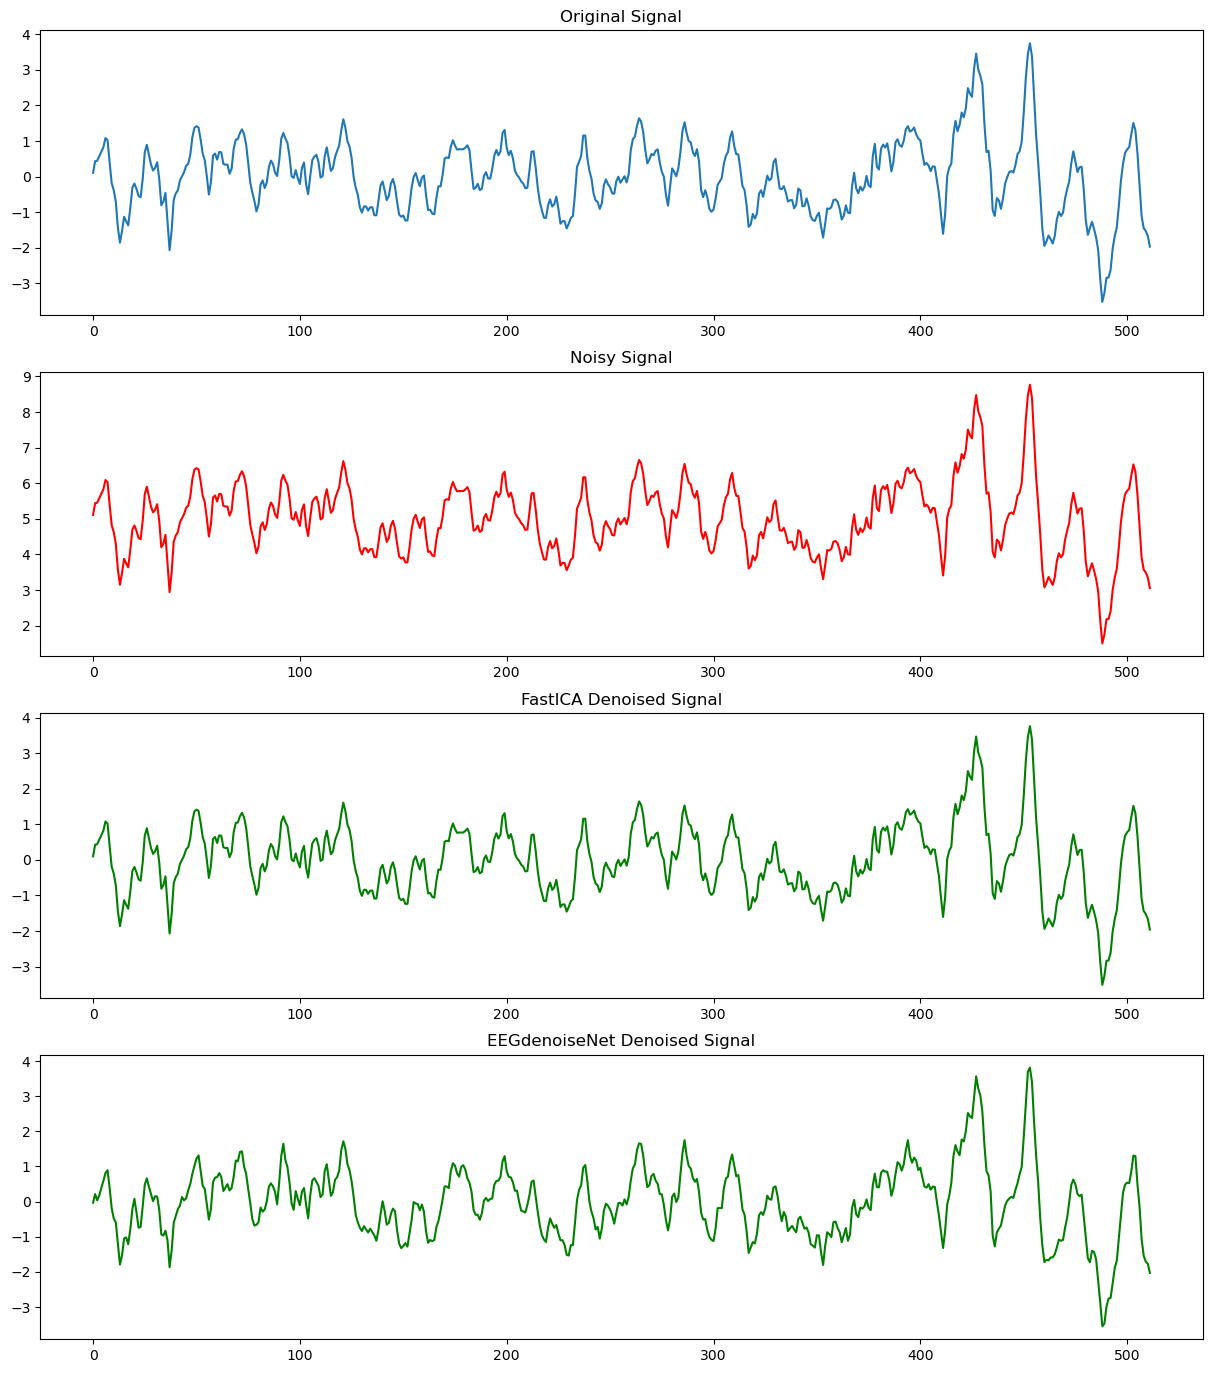

In [4]:
f, ax = plt.subplots(4, 1, figsize = (15, 17))
ax[0].plot(data['test']['ground_truth'][0]), ax[0].title.set_text("Original Signal")
ax[1].plot(data['test']['noisy_input'][0], color = 'red'), ax[1].title.set_text("Noisy Signal")
ax[2].plot(-1 * split_data, color = 'green'), ax[2].title.set_text("FastICA Denoised Signal")
ax[3].plot(data['test']['denoised'][0], color = 'green'), ax[3].title.set_text("EEGdenoiseNet Denoised Signal")
plt.show()

In [5]:
print(f"Correlation Coefficient (CC) for the example above: {cc(-1 * split_data, data['test']['ground_truth'][0]):.2f}")

Correlation Coefficient (CC) for the example above: 1.00


## 2. Denoising All Samples (1st Approach)

In [6]:
data = load_data('data/tDCS/')

Finished Loading EEG Data!


In [7]:
print('Applying FastICA Denoising to Test Set...')
metrics = {k:[] for k in ['rrmse_temporal', 'rrmse_spectral', 'cc']}
for signal in tqdm(range(data['test']['noisy_input'].shape[0])):
    ground_truth, noisy_input = data['test']['ground_truth'][signal], data['test']['noisy_input'][signal]
    fastICA = FastICA(n_components = 1, random_state = 42, whiten = 'unit-variance')
    split_data = fastICA.fit_transform(noisy_input.reshape(512, 1)).reshape(512)
    denoised_signal = -1 * split_data
    metrics['rrmse_temporal'].append(rrmse_temporal(denoised_signal, ground_truth))
    metrics['rrmse_spectral'].append(rrmse_spectral(denoised_signal, ground_truth))
    metrics['cc'].append(cc(denoised_signal, ground_truth))
print('Finished Denoising Process!')
avg_metrics = {k: np.mean(v) for k,v in metrics.items()}
print('Average Metrics:', avg_metrics)

Applying FastICA Denoising to Test Set...


100%|█████████████████████████████████████████████████████████████████████████████| 4510/4510 [00:06<00:00, 674.10it/s]

Finished Denoising Process!
Average Metrics: {'rrmse_temporal': 0.7613419923168726, 'rrmse_spectral': 0.0016855076798199461, 'cc': 0.2559312398563675}


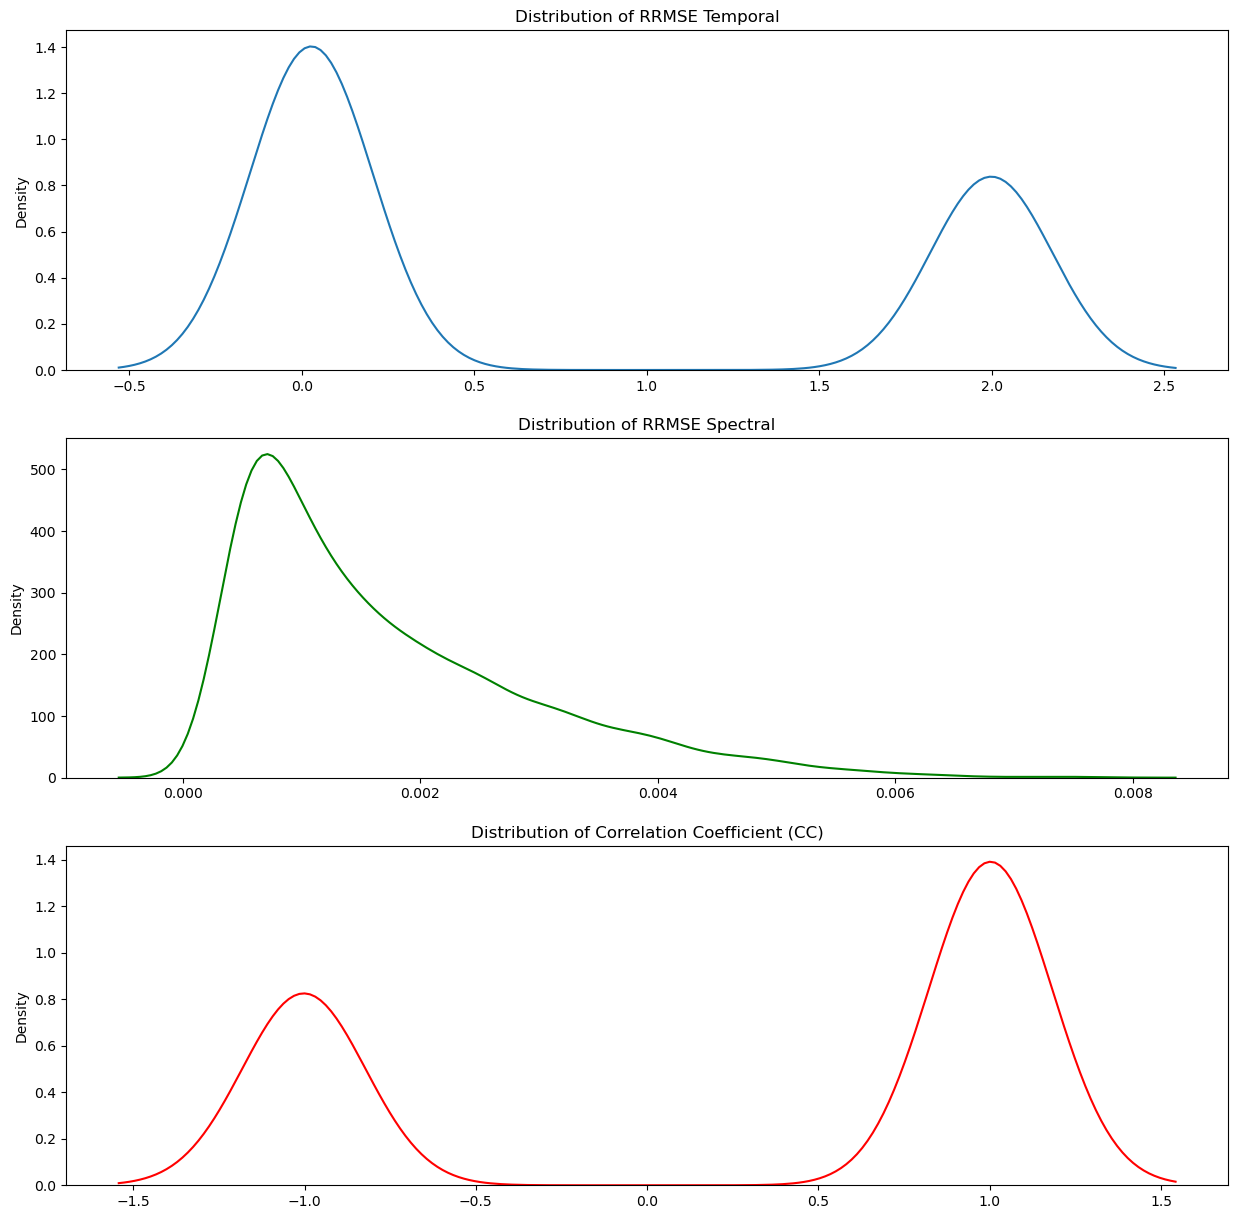

In [8]:
import warnings
warnings.simplefilter(action='ignore', category = FutureWarning)

f, ax = plt.subplots(3, 1, figsize = (15, 15))
sns.kdeplot(metrics['rrmse_temporal'], ax = ax[0]), ax[0].title.set_text("Distribution of RRMSE Temporal")
sns.kdeplot(metrics['rrmse_spectral'], ax = ax[1], color = 'green'), ax[1].title.set_text("Distribution of RRMSE Spectral")
sns.kdeplot(metrics['cc'], ax = ax[2], color = 'red'), ax[2].title.set_text("Distribution of Correlation Coefficient (CC)")
plt.show()

## 3. Solving the Inverse-Signal Problem

`FastICA` will sometimes yield the **inverted** denoised signal. For that reason, we propose below a simple (unsupervised) solution to this problem:

1. Compute the **Fourier Transform** of both the original noisy input and the denoised signal obtained through the `FastICA` algorithm.
2. Generate a *binary* **descriptor** (for each signal) from the signs of the amplitude coefficients obtained by taking the FFTs.
3. Compute the **cosine similarity** between both descriptors. If negative, **invert** the denoised signal.

Let's look at an example in which the denoised signal is inverted...

In [9]:
min_cc_sample = np.argmin(metrics['cc'])
print(min_cc_sample)

4489


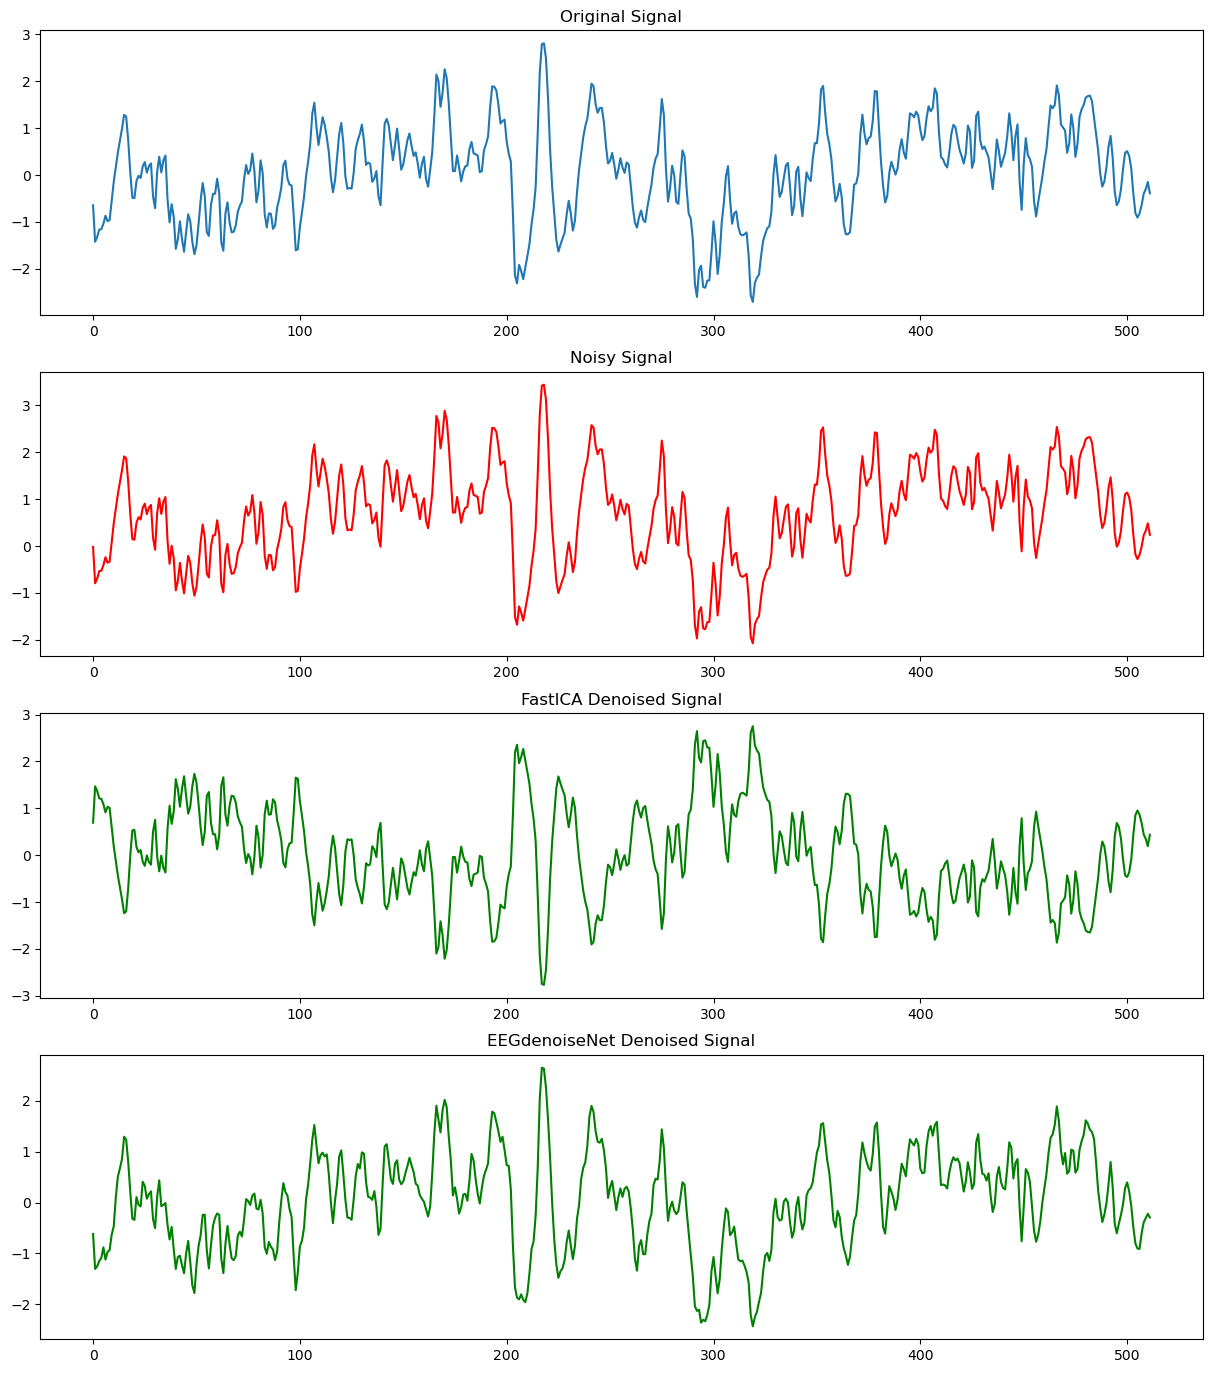

In [10]:
f, ax = plt.subplots(4, 1, figsize = (15, 17))
ax[0].plot(data['test']['ground_truth'][min_cc_sample]), ax[0].title.set_text("Original Signal")
ax[1].plot(data['test']['noisy_input'][min_cc_sample], color = 'red'), ax[1].title.set_text("Noisy Signal")
fastICA = FastICA(n_components = 1, random_state = 42, whiten = 'unit-variance')
split_data = fastICA.fit_transform(data['test']['noisy_input'][min_cc_sample].reshape(512, 1)).reshape(512)
ax[2].plot(-1 * split_data, color = 'green'), ax[2].title.set_text("FastICA Denoised Signal")
ax[3].plot(data['test']['denoised'][min_cc_sample], color = 'green'), ax[3].title.set_text("EEGdenoiseNet Denoised Signal")
plt.show()

In [11]:
print(f"Correlation Coefficient (CC) for the example above: {cc(-1 * split_data, data['test']['ground_truth'][min_cc_sample]):.2f}")
print(f"Correlation Coefficient (CC) for the example above: {cc(np.abs(split_data), np.abs(data['test']['ground_truth'][min_cc_sample])):.2f}")

Correlation Coefficient (CC) for the example above: -1.00
Correlation Coefficient (CC) for the example above: 1.00


In [12]:
from numpy.fft import fft

ica_pattern = np.sign(np.real(fft(-split_data)))
ground_truth_pattern = np.sign(np.real(fft(data['test']['noisy_input'][min_cc_sample])))

print(ica_pattern[:10], ground_truth_pattern[:10])

[ 1. -1.  1.  1. -1.  1. -1.  1.  1. -1.] [ 1.  1. -1. -1.  1. -1.  1. -1. -1.  1.]


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(ica_pattern.reshape(1,-1), ground_truth_pattern.reshape(1,-1))[0,0]

-0.9960937499999999

## 4. Denosing Samples (w/ Inverse-Signal Trick)

In [8]:
data = load_data('data/tDCS/')

Finished Loading EEG Data!


In [9]:
from numpy.fft import fft
from sklearn.metrics.pairwise import cosine_similarity

print('Applying FastICA Denoising to Test Set...')
metrics = {k:[] for k in ['rrmse_temporal', 'rrmse_spectral', 'cc']}
for signal in tqdm(range(data['test']['noisy_input'].shape[0])):
    ground_truth, noisy_input = data['test']['ground_truth'][signal], data['test']['noisy_input'][signal]
    fastICA = FastICA(n_components = 1, random_state = 42, whiten = 'unit-variance')
    denoised_signal = fastICA.fit_transform(noisy_input.reshape(512, 1)).reshape(512)
    # Apply Inverse-Signal Trick
    ica_pattern, input_pattern = np.sign(np.real(fft(denoised_signal))), np.sign(np.real(fft(noisy_input)))
    pattern_similarity = cosine_similarity(ica_pattern.reshape(1,-1), input_pattern.reshape(1,-1))[0,0]
    if pattern_similarity < 0:
        denoised_signal = -1 * denoised_signal
    metrics['rrmse_temporal'].append(rrmse_temporal(denoised_signal, ground_truth))
    metrics['rrmse_spectral'].append(rrmse_spectral(denoised_signal, ground_truth))
    metrics['cc'].append(cc(denoised_signal, ground_truth))
print('Finished Denoising Process!')
avg_metrics = {k: np.mean(v) for k,v in metrics.items()}
print('Average Metrics:', avg_metrics)

Applying FastICA Denoising to Test Set...


100%|█████████████████████████████████████████████████████████████████████████████| 4510/4510 [00:07<00:00, 564.67it/s]

Finished Denoising Process!
Average Metrics: {'rrmse_temporal': 0.02981817654176491, 'rrmse_spectral': 0.0016855076798199461, 'cc': 1.0019527971562452}


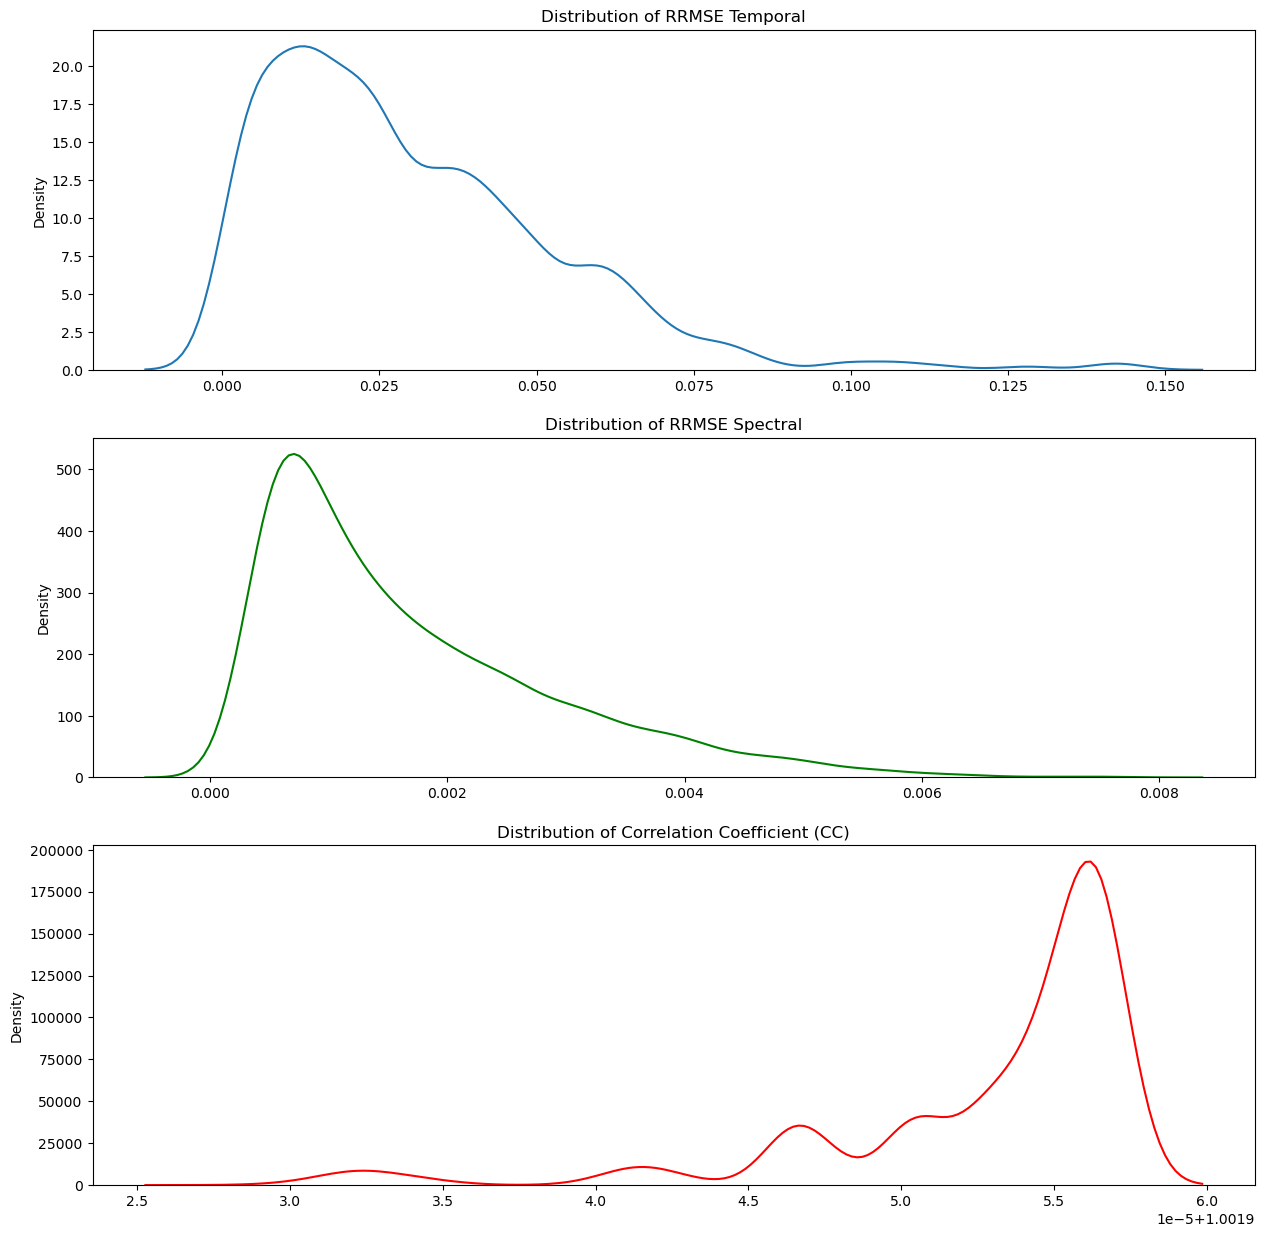

In [36]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

f, ax = plt.subplots(3, 1, figsize = (15, 15))
sns.kdeplot(metrics['rrmse_temporal'], ax = ax[0]), ax[0].title.set_text("Distribution of RRMSE Temporal")
sns.kdeplot(metrics['rrmse_spectral'], ax = ax[1], color = 'green'), ax[1].title.set_text("Distribution of RRMSE Spectral")
sns.kdeplot(metrics['cc'], ax = ax[2], color = 'red'), ax[2].title.set_text("Distribution of Correlation Coefficient (CC)")
plt.show()